In [432]:
from catboost import CatBoostRegressor, CatBoostClassifier
import lightgbm as lgbm
from pytorch_tabnet.tab_model import TabNetClassifier
import numpy as np 
import pandas as pd 
import os 
import json
import ccxt
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_ta as ta
from sklearn.utils.class_weight import compute_class_weight
from random import randint

In [433]:
with open('BTC_USDT-4h-10.json') as f:
    d = json.load(f)
    
chart_df = pd.DataFrame(d)
chart_df = chart_df.rename(columns={0:"timestamp",
                                    1:"open",
                                    2:"high",
                                    3:"low",
                                    4:"close",
                                    5:"volume"})

In [434]:
def process(df): 
    binance = ccxt.binance() 
    dates = df['timestamp'].values 
    timestamp = [] 
    for i in range(len(dates)): 
        date_string = binance.iso8601(int(dates[i])) 
        date_string = date_string[:10] + " " + date_string[11:-5] 
        timestamp.append(date_string) 
    df['datetime'] = timestamp 
    df = df.drop(columns={'timestamp'})
    return df

In [435]:
chart_df = process(chart_df)
chart_df.tail() 

,open,high,low,close,volume,datetime
10964,21210.06,21285.08,21069.11,21251.38,21730.29782,2022-08-21 04:00:00
10965,21250.21,21570.00,21224.48,21524.39,34690.60227,2022-08-21 08:00:00
10966,21525.57,21587.74,21314.88,21420.20,24843.69947,2022-08-21 12:00:00
10967,21419.00,21557.26,21330.75,21512.01,21034.03801,2022-08-21 16:00:00
10968,21512.01,21800.00,21277.73,21515.61,35006.75105,2022-08-21 20:00:00


In [436]:
hours, days, months, years = [],[],[],[] 

for dt in tqdm(chart_df['datetime']):
    hour = pd.to_datetime(dt).hour 
    day = pd.to_datetime(dt).day 
    month = pd.to_datetime(dt).month 
    year = pd.to_datetime(dt).year 
    hours.append(hour) 
    days.append(day) 
    months.append(month)
    years.append(year) 

chart_df['hours'] = hours 
chart_df['days'] = days 
chart_df['months'] = months 
chart_df['years'] = years

100%|██████████| 10969/10969 [00:01<00:00, 5517.00it/s]


In [437]:
chart_df.tail() 

,open,high,low,close,volume,datetime,hours,days,months,years
10964,21210.06,21285.08,21069.11,21251.38,21730.29782,2022-08-21 04:00:00,4,21,8,2022
10965,21250.21,21570.00,21224.48,21524.39,34690.60227,2022-08-21 08:00:00,8,21,8,2022
10966,21525.57,21587.74,21314.88,21420.20,24843.69947,2022-08-21 12:00:00,12,21,8,2022
10967,21419.00,21557.26,21330.75,21512.01,21034.03801,2022-08-21 16:00:00,16,21,8,2022
10968,21512.01,21800.00,21277.73,21515.61,35006.75105,2022-08-21 20:00:00,20,21,8,2022


In [438]:
targets = [] 
close = chart_df['close'].values 
high = chart_df['high'].values 
low = chart_df['low'].values 

threshold = 0.0075

for i in range(close.shape[0]-1): 
    high_volatility = (high[i+1] - close[i]) / close[i] 
    low_volatility = (low[i+1] - close[i]) / close[i] 
    if np.abs(high_volatility) >= np.abs(low_volatility): 
        if high_volatility >= threshold:
            targets.append(0) # long, tp=+0.75% 
        else:
            targets.append(2) # long, tp=+0.4% 
    elif np.abs(high_volatility) < np.abs(low_volatility):
        if low_volatility <= -threshold: 
            targets.append(1) # short, tp=-0.75%
        else:
            targets.append(3) # short, tp=-0.4%  
    
targets.append(None) 

chart_df['Targets'] = targets 
chart_df.head(5)

,open,high,low,close,volume,datetime,hours,days,months,years,Targets
0,4261.48,4349.99,4261.32,4349.99,82.088865,2017-08-17 04:00:00,4,17,8,2017,0.0
1,4333.32,4485.39,4333.32,4427.30,63.619882,2017-08-17 08:00:00,8,17,8,2017,1.0
2,4436.06,4485.39,4333.42,4352.34,174.562001,2017-08-17 12:00:00,12,17,8,2017,1.0
3,4352.33,4354.84,4200.74,4325.23,225.109716,2017-08-17 16:00:00,16,17,8,2017,1.0
4,4307.56,4369.69,4258.56,4285.08,249.769913,2017-08-17 20:00:00,20,17,8,2017,1.0


In [439]:
print("total shape = {}".format(chart_df.shape))

total shape = (10969, 11)


/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

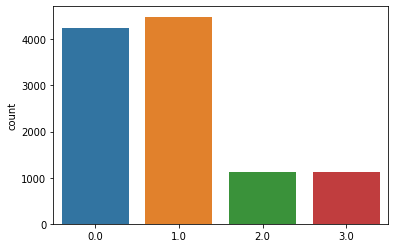

In [441]:
sns.countplot(chart_df['Targets'].values)

In [442]:
chart_df.set_index(pd.DatetimeIndex(chart_df["datetime"]), inplace=True)

### addition of chart features ### 
chart_df["bop"] = chart_df.ta.bop(lookahead=False) 
chart_df["ebsw"] = chart_df.ta.ebsw(lookahead=False) 
chart_df["cmf"] = chart_df.ta.cmf(lookahead=False) 
chart_df["vwap"] = chart_df.ta.vwap(lookahead=False) 
chart_df["rsi/100"] = chart_df.ta.rsi(lookahead=False) / 100
chart_df["high/low"] = chart_df["high"] / chart_df["low"] 
chart_df["close/open"] = chart_df["close"] / chart_df["open"] 
chart_df["high/open"] = chart_df["high"] / chart_df["open"] 
chart_df["low/open"] = chart_df["low"] / chart_df["open"] 
chart_df["hwma"] = chart_df.ta.hwma(lookahead=False) 
chart_df["linreg"] = chart_df.ta.linreg(lookahead=False) 
chart_df["hwma/close"] = chart_df["hwma"] / chart_df["close"] 
chart_df["linreg/close"] = chart_df["linreg"] / chart_df["close"] 



### addition of moving average features ### 
windows = [5, 10, 20, 60, 120]
for window in windows:
    chart_df["close_ma{}".format(window)] = chart_df["close"].rolling(window).mean() 
    chart_df["close_ma{}_ratio".format(window)] = (chart_df["close"] - chart_df["close_ma{}".format(window)])/chart_df["close_ma{}".format(window)]    
    
### addition of recent differenced features ### 
for l in range(1, 6): 
    for col in ["open", "high", "low", "close", "volume", "vwap"]:
        val = chart_df[col].values 
        val_ret = [None for _ in range(l)]
        for i in range(l, len(val)):
            if val[i-l] == 0: 
                ret = 1 
            else:
                ret = val[i] / val[i-l]  
            val_ret.append(ret) 
        chart_df["{}_change_{}".format(col, l)] = val_ret
        
### drop unnecessary columns ### 
chart_df.drop(columns={"open","high","low","close","volume","vwap","hwma","linreg",
                       "close_ma5","close_ma10","close_ma20", "close_ma60","close_ma120"}, inplace=True) 


chart_df.dropna(inplace=True)

print(chart_df.shape)  


(10849, 51)


In [443]:
columns = chart_df.columns 

train_columns = [] 

for c in columns:
    if c not in ["years","datetime","Targets"]: 
        train_columns.append(c) 
        
        
train_idx = int(chart_df.shape[0] * 0.8) 
val_idx = int(chart_df.shape[0] * 0.1)
train_df, val_df, test_df = chart_df.iloc[:train_idx], chart_df.iloc[train_idx:train_idx+val_idx], chart_df.iloc[train_idx+val_idx:]


train_df.shape, val_df.shape, test_df.shape

((8679, 51), (1084, 51), (1086, 51))

In [444]:
chart_df.dropna(inplace=True)
X_train = train_df[train_columns] 
Y_train = train_df["Targets"]

X_val = val_df[train_columns] 
Y_val = val_df["Targets"] 

X_test = test_df[train_columns] 
Y_test = test_df["Targets"] 


class_weights = compute_class_weight(class_weight = "balanced",
                                     classes = np.unique(Y_train),
                                     y = Y_train) 

class_weights

array([0.65690282, 0.6176345 , 2.33055854, 2.32805794])

In [445]:
params = {"objective":"multiclass", 
          "metric":"multi_logloss", 
          "num_class":4, 
          "boosting":"goss"} 

train_ds = lgbm.Dataset(X_train, label=Y_train) 
val_ds = lgbm.Dataset(X_val, label=Y_val) 
model = lgbm.train(params, train_ds, 1000, val_ds, verbose_eval=100) 


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11526
[LightGBM] [Info] Number of data points in the train set: 8679, number of used features: 48
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score -0.966075
[LightGBM] [Info] Start training from score -0.904436
[LightGBM] [Info] Start training from score -2.232402
[LightGBM] [Info] Start training from score -2.231329
[100]	valid_0's multi_logloss: 1.16361
[200]	valid_0's multi_logloss: 1.25963
[300]	valid_0's multi_logloss: 1.35788
[400]	valid_0's multi_logloss: 1.45831
[500]	valid_0's multi_logloss: 1.55018
[600]	valid_0's multi_logloss: 1.63959
[700]	valid_0's multi_logloss: 1.72351
[800]	valid_0's multi_logloss: 1.82852
[900]	valid_0's multi_logloss: 1.93388
[1000]	valid_0's multi_logloss: 2.03559


In [446]:
Y_pred = model.predict(X_test) 
classes = np.argmax(Y_pred, axis=1) 

cnt = 0 
for i in range(len(classes)):
    if classes[i] == Y_test.values[i]:
        cnt += 1 
        
cnt / len(classes) * 100 


42.7255985267035

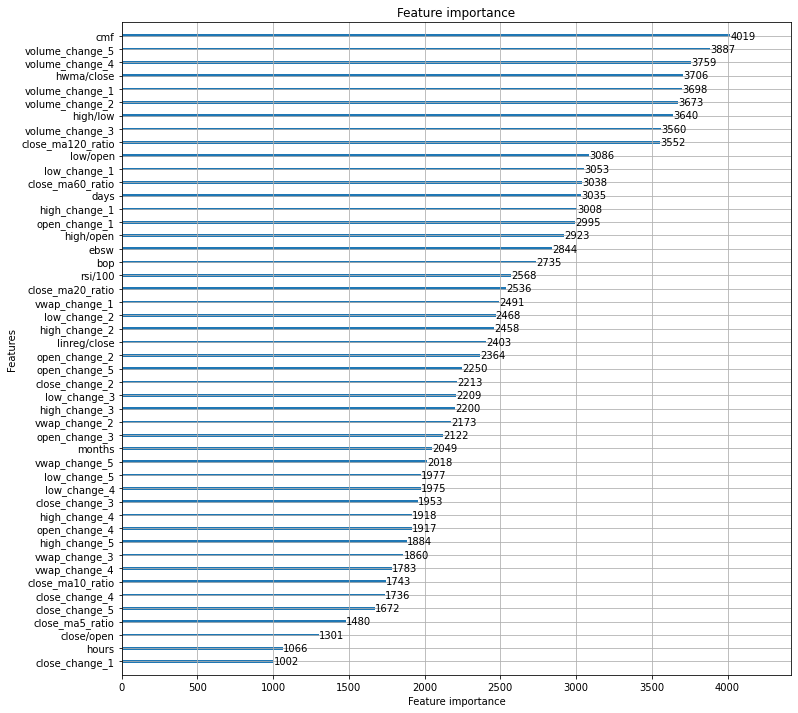

In [407]:
ax = lgbm.plot_importance(model)
fig = ax.figure 
fig.set_size_inches(12, 12)

In [447]:
import joblib
#joblib.dump(model, 'lgb.pkl')


In [448]:
lgbm_saved = joblib.load('lgb.pkl')


In [449]:
lgbm_saved

In [410]:
classes = np.argmax(Y_pred, axis=1) 

classes

array([0, 0, 0, ..., 1, 1, 1])

In [450]:
cnt = 0 
for i in range(len(classes)):
    if classes[i] == Y_test.values[i]:
        cnt += 1 
        
cnt / len(classes) * 100 

42.7255985267035

In [414]:
rand_agent = [randint(0,3) for _ in range(len(Y_test))] 

cnt = 0 
for i in range(len(rand_agent)):
    if rand_agent[i] == Y_test.values[i]:
        cnt += 1 
        
cnt / len(Y_pred) * 100 

25.59852670349908

In [415]:
all_long = [0 for _ in range(len(Y_test))] 
cnt = 0 
for i in range(len(all_long)):
    if all_long[i] == Y_test.values[i]:
        cnt += 1 
        
cnt / len(Y_pred) * 100 

40.79189686924494

In [416]:
all_short = [1 for _ in range(len(Y_test))] 
cnt = 0 
for i in range(len(all_short)):
    if all_short[i] == Y_test.values[i]:
        cnt += 1 
        
cnt / len(Y_pred) * 100 

39.50276243093923

In [417]:
all_long = [2 for _ in range(len(Y_test))] 
cnt = 0 
for i in range(len(all_long)):
    if all_long[i] == Y_test.values[i]:
        cnt += 1 

cnt / len(all_long) * 100

8.931860036832411

In [418]:
all_short = [3 for _ in range(len(Y_test))] 
cnt = 0 
for i in range(len(all_short)):
    if all_short[i] == Y_test.values[i]:
        cnt += 1 

cnt / len(all_short) * 100

10.773480662983426